## Importer les librairie nécessaire

In [3]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import mode
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4




####
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## importer les fichiers 


In [3]:
train = pd.read_csv('data/train.csv') 
test = pd.read_csv('data/test.csv')
event_type = pd.read_csv('data/event_type.csv')
log_feature = pd.read_csv('data/log_feature.csv')
resource_type = pd.read_csv('data/resource_type.csv')
severity_type = pd.read_csv('data/severity_type.csv')

In [4]:
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


### Combiner test & train:

En général, j’ai tendance à combiner les fichiers train et test en vue de l’analyse en ajoutant une fonction source qui enregistre l’observation de l’observation. Après combinaison, les données ressemblent à:

In [5]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train,test], ignore_index=True)
data.head()

,fault_severity,id,location,source
0,1.0,14121,location 118,train
1,0.0,9320,location 91,train
2,1.0,14394,location 152,train
3,1.0,8218,location 931,train
4,0.0,14804,location 120,train


Colonnes:

- id: identifiant unique pour chaque emplacement et horodatage
- emplacement: identifiant unique pour chaque emplacement
- fault_severity: variable de résultat
- Principales observations

18552 identifiant unique (train: 7381 | test: 11171)
1126 lieux uniques

In [6]:
print (train.shape) 
print (test.shape) 
print (data.shape) 
print (event_type.shape) 
print (log_feature.shape) 
print (resource_type.shape) 
print (severity_type.shape) 

(7381, 4)
(11171, 3)
(18552, 4)
(31170, 2)
(58671, 3)
(21076, 2)
(18552, 2)


In [7]:
print (len(data['location'].unique())) 

1126


In [8]:
data['fault_severity'].value_counts()

0.0    4784
1.0    1871
2.0     726
Name: fault_severity, dtype: int64

In [9]:
print (log_feature.head()) 
print (resource_type.head()) 
print (severity_type.head()) 

     id  log_feature  volume
0  6597   feature 68       6
1  8011   feature 68       7
2  2597   feature 68       1
3  5022  feature 172       2
4  5022   feature 56       1
     id    resource_type
0  6597  resource_type 8
1  8011  resource_type 8
2  2597  resource_type 8
3  5022  resource_type 8
4  6852  resource_type 8
     id    severity_type
0  6597  severity_type 2
1  8011  severity_type 2
2  2597  severity_type 2
3  5022  severity_type 1
4  6852  severity_type 1


## Event type:

In [10]:
print (event_type.head()) 

     id     event_type
0  6597  event_type 11
1  8011  event_type 15
2  2597  event_type 15
3  5022  event_type 15
4  5022  event_type 11


Observations initiales:

- 18552 identifiant unique (identique au train et à l'essai combinés)
- 53 événements uniques

Inférences:

- Étant donné que le nombre de lignes est supérieur au nombre d'identifiants uniques, plusieurs événements sont enregistrés pour chaque identifiant. Par conséquent, nous devons combiner ces données au niveau "id" avant de les fusionner avec le cadre de données d'origine.
- Il existe 53 valeurs uniques qui pourraient ne pas être toutes significatives. Nous pouvons donc envisager d’explorer davantage cette question.

In [11]:
event_type = event_type.merge(data, on='id')
event_type.head()

,id,event_type,fault_severity,location,source
0,6597,event_type 11,NaN,location 1,test
1,8011,event_type 15,0.0,location 1,train
2,2597,event_type 15,NaN,location 1,test
3,5022,event_type 15,NaN,location 1,test
4,5022,event_type 11,NaN,location 1,test


In [12]:
event_type_unq = pd.DataFrame(event_type['event_type'].value_counts())
event_type_unq.head()

,event_type
event_type 11,7888
event_type 35,6615
event_type 34,5927
event_type 15,4395
event_type 20,1458


In [13]:
#Determiner le  %  d'échantillon de formations:
event_type_unq['PercTrain'] = event_type.pivot_table(values='source',index='event_type',aggfunc=lambda x: sum(x=='train')/float(len(x)))
event_type_unq.head()

,event_type,PercTrain
event_type 11,7888,0.388945
event_type 35,6615,0.407105
event_type 34,5927,0.406783
event_type 15,4395,0.392264
event_type 20,1458,0.382030


In [14]:
#Déterminez le mode de chacun:
event_type_unq['Mode_Severity'] = event_type.loc[event_type['source']=='train'].pivot_table(values='fault_severity',index='event_type', aggfunc=lambda x: mode(x).mode[0])

In [15]:
event_type_unq.iloc[-15:]

,event_type,PercTrain,Mode_Severity
event_type 49,17,0.352941,2.0
event_type 19,14,0.285714,2.0
event_type 9,14,0.214286,0.0
event_type 37,10,0.400000,0.0
event_type 31,10,0.500000,1.0
event_type 12,6,0.333333,0.0
event_type 25,5,0.200000,0.0
event_type 51,4,0.750000,0.0
event_type 1,4,0.250000,0.0
event_type 17,3,0.000000,NaN


In [16]:
#define action pour chacun:
#initialiser:
event_type_unq['preprocess'] = event_type_unq.index.values

#remove ceux qui ne sont pas présents dans le train:
# event_type_unq ['prétraitement']. loc [event_type_unq ['PercTrain'] == 0] = 'Supprimer'

#remplacer les inférieurs avec le mode:
top_unchange = 33
event_type_unq['preprocess'].iloc[top_unchange:] = event_type_unq['Mode_Severity'].iloc[top_unchange:].apply(lambda x: 'Remove' if pd.isnull(x) else 'event_type others_%d'%int(x))

C:\Users\asus\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
print (event_type_unq['preprocess'].value_counts())
print (event_type_unq)

event_type others_0    10
event_type others_2     5
Remove                  4
event_type 5            1
event_type 10           1
event_type 7            1
event_type 29           1
event_type 30           1
event_type 15           1
event_type 22           1
event_type 20           1
event_type 42           1
event_type 28           1
event_type 24           1
event_type 46           1
event_type 18           1
event_type 54           1
event_type 45           1
event_type 26           1
event_type 50           1
event_type 23           1
event_type 43           1
event_type 6            1
event_type 40           1
event_type 21           1
event_type 32           1
event_type others_1     1
event_type 8            1
event_type 47           1
event_type 11           1
event_type 2            1
event_type 44           1
event_type 35           1
event_type 13           1
event_type 14           1
event_type 27           1
event_type 34           1
Name: preprocess, dtype: int64
       

In [18]:
#Merge preprocess into original and then into train:
event_type = event_type.merge(event_type_unq[['preprocess']], left_on='event_type',right_index=True)
print (event_type.head())
event_type['preprocess'].value_counts()

       id     event_type  fault_severity    location source     preprocess
0    6597  event_type 11             NaN  location 1   test  event_type 11
4    5022  event_type 11             NaN  location 1   test  event_type 11
5    6852  event_type 11             NaN  location 1   test  event_type 11
9   14838  event_type 11             NaN  location 1   test  event_type 11
11   2588  event_type 11             0.0  location 1  train  event_type 11


event_type 11          7888
event_type 35          6615
event_type 34          5927
event_type 15          4395
event_type 20          1458
event_type 54           684
event_type 13           582
event_type 42           478
event_type 44           466
event_type 23           429
event_type 14           330
event_type 43           306
event_type 22           223
event_type 50           154
event_type 10           145
event_type 21           136
event_type others_2      85
event_type others_0      84
event_type 18            73
event_type 47            69
event_type 26            65
event_type 32            63
event_type 30            60
event_type 45            53
event_type 24            46
event_type 27            44
event_type 29            42
event_type 40            40
event_type 46            38
event_type 2             37
event_type 28            32
event_type 8             29
event_type 6             28
event_type 5             26
event_type 7             24
event_type others_1 

In [19]:
event_type_merge = event_type.pivot_table(values='event_type',index='id',columns='preprocess',aggfunc=lambda x: len(x), fill_value=0)
event_type_merge.shape

(18552, 37)

In [20]:
data = data.merge(event_type_merge, left_on='id', right_index=True)
data.head()

,fault_severity,id,location,source,Remove,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,...,event_type 47,event_type 5,event_type 50,event_type 54,event_type 6,event_type 7,event_type 8,event_type others_0,event_type others_1,event_type others_2
0,1.0,14121,location 118,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,9320,location 91,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,14394,location 152,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,8218,location 931,train,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.0,14804,location 120,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:

print (data.shape)


(18552, 41)


## log features:

In [22]:
log_feature = pd.read_csv('data/log_feature.csv')
log_feature['log_feature'].value_counts().head()

feature 312    5267
feature 232    4754
feature 82     3472
feature 203    2823
feature 313    2145
Name: log_feature, dtype: int64

In [23]:
log_feature = log_feature.merge(data[['id','fault_severity','source']], on='id')
log_feature.head()

,id,log_feature,volume,fault_severity,source
0,6597,feature 68,6,NaN,test
1,8011,feature 68,7,0.0,train
2,2597,feature 68,1,NaN,test
3,5022,feature 172,2,NaN,test
4,5022,feature 56,1,NaN,test


Observations initiales:

- 18552 identifiant unique (identique au train et à l'essai combinés)
- 386 événements uniques
- Une colonne de volume supplémentaire qui spécifie une quantité associée à chaque variable

Inférences:

- Semblable à event_type, nous devons combiner ces données au niveau "id" avant de les fusionner avec le cadre de données d'origine.
- Il y a 386 valeurs uniques et nous devrions réfléchir davantage aux valeurs à incorporer dans le modèle.

In [24]:
log_feature_unq = pd.DataFrame(log_feature['log_feature'].value_counts())
log_feature_unq.head()

,log_feature
feature 312,5267
feature 232,4754
feature 82,3472
feature 203,2823
feature 313,2145


In [25]:
#Determiner le  % de training samples:
log_feature_unq['PercTrain'] = log_feature.pivot_table(values='source',index='log_feature',aggfunc=lambda x: sum(x=='train')/float(len(x)))
log_feature_unq.head()

,log_feature,PercTrain
feature 312,5267,0.411430
feature 232,4754,0.408919
feature 82,3472,0.393433
feature 203,2823,0.393199
feature 313,2145,0.421445


In [26]:
# Déterminez le mode de chacun:
log_feature_unq['Mode_Severity'] = log_feature.loc[log_feature['source']=='train'].pivot_table(values='fault_severity',index='log_feature', aggfunc=lambda x: mode(x).mode[0])

In [27]:
len(log_feature_unq)

386

In [28]:
log_feature_unq.ix[100:130]

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,log_feature,PercTrain,Mode_Severity
feature 318,44,0.477273,0.0
feature 132,42,0.404762,1.0
feature 66,42,0.238095,1.0
feature 218,40,0.500000,1.0
feature 83,40,0.500000,2.0
feature 240,39,0.333333,0.0
feature 188,38,0.263158,1.0
feature 284,38,0.526316,0.0
feature 239,38,0.500000,0.0
feature 63,37,0.378378,0.0


In [29]:
#define action for each:
#initialize:
log_feature_unq['preprocess'] = log_feature_unq.index.values

#remove the ones all in train
log_feature_unq['preprocess'].loc[log_feature_unq['PercTrain']==1] = np.nan

#replace the lower ones with mode:
top_unchange = 128
log_feature_unq['preprocess'].iloc[top_unchange:] = log_feature_unq['Mode_Severity'].iloc[top_unchange:].apply(lambda x: 'Remove' if pd.isnull(x) else 'feature others_%d'%int(x))
print (log_feature_unq['preprocess'].value_counts())
print (log_feature_unq)

feature others_0    111
feature others_1     64
Remove               55
feature others_2     28
feature 160           1
feature 181           1
feature 66            1
feature 218           1
feature 62            1
feature 345           1
feature 229           1
feature 171           1
feature 232           1
feature 103           1
feature 83            1
feature 283           1
feature 206           1
feature 308           1
feature 8             1
feature 374           1
feature 54            1
feature 167           1
feature 239           1
feature 155           1
feature 109           1
feature 71            1
feature 101           1
feature 52            1
feature 81            1
feature 94            1
                   ... 
feature 354           1
feature 85            1
feature 195           1
feature 74            1
feature 157           1
feature 132           1
feature 310           1
feature 285           1
feature 118           1
feature 289           1
feature 223     

C:\Users\asus\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [30]:
#Fusionner le prétraitement dans l'original puis dans le train:
log_feature = log_feature.merge(log_feature_unq[['preprocess']], left_on='log_feature',right_index=True)
print (event_type.head())
log_feature['preprocess'].value_counts()

       id     event_type  fault_severity    location source     preprocess
0    6597  event_type 11             NaN  location 1   test  event_type 11
4    5022  event_type 11             NaN  location 1   test  event_type 11
5    6852  event_type 11             NaN  location 1   test  event_type 11
9   14838  event_type 11             NaN  location 1   test  event_type 11
11   2588  event_type 11             0.0  location 1  train  event_type 11


feature 312         5267
feature 232         4754
feature 82          3472
feature 203         2823
feature 313         2145
feature 233         1901
feature 307         1597
feature 54          1573
feature 170         1526
feature 71          1514
feature 315         1495
feature 134         1419
feature 80          1336
feature 235         1294
feature 193         1160
feature 219         1152
feature 68          1093
feature 227         1080
feature 314          950
feature 201          902
feature 234          882
feature 73           868
feature 195          783
feature others_0     777
feature 301          707
feature 309          627
feature 55           564
feature 229          560
feature 273          491
feature others_1     488
                    ... 
feature 378           46
feature 318           44
feature 370           44
feature 132           42
feature 66            42
feature 218           40
feature 83            40
feature 240           39
feature 188           38


In [31]:
log_feature_merge = log_feature.pivot_table(values='volume',index='id',columns='preprocess',aggfunc=np.sum, fill_value=0)
log_feature_merge.shape

(18552, 132)

In [32]:
log_feature_merge.sum().sum()

568246

In [33]:
data = data.merge(log_feature_merge, left_on='id', right_index=True)
data.head()

,fault_severity,id,location,source,Remove_x,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,...,feature 82,feature 83,feature 85,feature 86,feature 87,feature 94,feature 95,feature others_0,feature others_1,feature others_2
0,1.0,14121,location 118,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,9320,location 91,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,14394,location 152,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,8218,location 931,train,0,0,1,0,0,1,...,12,0,0,0,0,0,0,0,0,0
4,0.0,14804,location 120,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,4,0,0


## Resource Type:

In [34]:
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


Observations initiales:

- 18552 identifiant unique (identique au train et à l'essai combinés)
- 10 événements uniques

Inférences:

- Semblable à event_type, nous devons combiner ces données au niveau "id" avant de les fusionner avec le cadre de données d'origine.
- Il y a moins de valeurs uniques ici

In [35]:
resource_type['resource_type'].value_counts()

resource_type 8     10268
resource_type 2      8918
resource_type 6       582
resource_type 7       498
resource_type 4       330
resource_type 9       190
resource_type 3       145
resource_type 10       73
resource_type 1        58
resource_type 5        14
Name: resource_type, dtype: int64

In [36]:
resource_type = resource_type.merge(data[['id','fault_severity','source']], on='id')
resource_type.head()

,id,resource_type,fault_severity,source
0,6597,resource_type 8,NaN,test
1,8011,resource_type 8,0.0,train
2,2597,resource_type 8,NaN,test
3,5022,resource_type 8,NaN,test
4,6852,resource_type 8,NaN,test


In [37]:
resource_type_unq = pd.DataFrame(resource_type['resource_type'].value_counts())
resource_type_unq.head()

,resource_type
resource_type 8,10268
resource_type 2,8918
resource_type 6,582
resource_type 7,498
resource_type 4,330


In [38]:
#Determine % of training samples:
resource_type_unq['PercTrain'] = resource_type.pivot_table(values='source',index='resource_type',aggfunc=lambda x: sum(x=='train')/float(len(x)))
resource_type_unq.head()
#Determine the mode of each:
resource_type_unq['Mode_Severity'] = resource_type.loc[resource_type['source']=='train'].pivot_table(values='fault_severity',index='resource_type', aggfunc=lambda x: mode(x).mode[0])
resource_type_unq

,resource_type,PercTrain,Mode_Severity
resource_type 8,10268,0.394527,0.0
resource_type 2,8918,0.401996,0.0
resource_type 6,582,0.424399,1.0
resource_type 7,498,0.451807,0.0
resource_type 4,330,0.436364,0.0
resource_type 9,190,0.405263,0.0
resource_type 3,145,0.400000,1.0
resource_type 10,73,0.479452,0.0
resource_type 1,58,0.586207,1.0
resource_type 5,14,0.285714,2.0


In [39]:
resource_type.loc[resource_type['resource_type']=='resource_type 5']

,id,resource_type,fault_severity,source
5653,5475,resource_type 5,NaN,test
5655,5915,resource_type 5,NaN,test
5657,9989,resource_type 5,NaN,test
6936,7378,resource_type 5,2.0,train
7064,9373,resource_type 5,2.0,train
7073,9677,resource_type 5,NaN,test
7223,6322,resource_type 5,NaN,test
10786,15655,resource_type 5,NaN,test
10790,11683,resource_type 5,NaN,test
10793,1616,resource_type 5,2.0,train


Since all are important, we'll leave this as it is:

In [40]:
resource_type_merge = resource_type.pivot_table(values='source',index='id',columns='resource_type',aggfunc=lambda x: len(x), fill_value=0)
# resource_type_merge.shape
data = data.merge(resource_type_merge, left_on='id', right_index=True)
data.head()

,fault_severity,id,location,source,Remove_x,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,...,resource_type 1,resource_type 10,resource_type 2,resource_type 3,resource_type 4,resource_type 5,resource_type 6,resource_type 7,resource_type 8,resource_type 9
0,1.0,14121,location 118,train,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.0,9320,location 91,train,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1.0,14394,location 152,train,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1.0,8218,location 931,train,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0.0,14804,location 120,train,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [41]:
data.shape

(18552, 183)

## Severity Type:

In [42]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


Observations initiales:

- 18552 identifiant unique (identique au train et à l'essai combinés)
- 5 événements uniques

Inférences:

- Il a seulement 1 valeur pour chaque identifiant
- On peut soit le garder comme un seul tableau, soit créer des variables factices

In [43]:
severity_type['severity_type'].value_counts()

severity_type 2    8737
severity_type 1    8728
severity_type 4    1014
severity_type 5      65
severity_type 3       8
Name: severity_type, dtype: int64

In [44]:
severity_type = severity_type.merge(data[['id','fault_severity','source']], on='id')
severity_type.head()

,id,severity_type,fault_severity,source
0,6597,severity_type 2,NaN,test
1,8011,severity_type 2,0.0,train
2,2597,severity_type 2,NaN,test
3,5022,severity_type 1,NaN,test
4,6852,severity_type 1,NaN,test


In [45]:
severity_type_unq = pd.DataFrame(severity_type['severity_type'].value_counts())
severity_type_unq.head()

,severity_type
severity_type 2,8737
severity_type 1,8728
severity_type 4,1014
severity_type 5,65
severity_type 3,8


In [46]:
#Determine % of training samples:
severity_type_unq['PercTrain'] = severity_type.pivot_table(values='source',index='severity_type',aggfunc=lambda x: sum(x=='train')/float(len(x)))
severity_type_unq.head()
#Determine the mode of each:
severity_type_unq['Mode_Severity'] = severity_type.loc[severity_type['source']=='train'].pivot_table(values='fault_severity',index='severity_type', aggfunc=lambda x: mode(x).mode[0])
severity_type_unq

,severity_type,PercTrain,Mode_Severity
severity_type 2,8737,0.411011,0.0
severity_type 1,8728,0.386687,0.0
severity_type 4,1014,0.382643,0.0
severity_type 5,65,0.353846,0.0
severity_type 3,8,0.500000,0.0


In [47]:
severity_type.loc[event_type['source']=='train'].pivot_table(values='fault_severity',index='severity_type', aggfunc=lambda x: mode(x))

,fault_severity
severity_type,
severity_type 1,"([0.0], [693.0])"
severity_type 2,"([0.0], [1085.0])"
severity_type 3,"([0.0], [3.0])"
severity_type 4,"([0.0], [156.0])"
severity_type 5,"([0.0], [5.0])"


In [48]:
#Merge last two:
# severity_type.loc[severity_type['severity_type']=='severity_type 3','severity_type'] = 'severity_type 5'

In [49]:
severity_type_merge = severity_type.pivot_table(values='source',index='id',columns='severity_type',aggfunc=lambda x: len(x), fill_value=0)
event_type_merge.head()

preprocess,Remove,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,event_type 18,event_type 2,event_type 20,event_type 21,...,event_type 47,event_type 5,event_type 50,event_type 54,event_type 6,event_type 7,event_type 8,event_type others_0,event_type others_1,event_type others_2
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
data = data.merge(severity_type_merge, left_on='id', right_index=True)
data.head(), data.shape

(   fault_severity     id      location source  Remove_x  event_type 10  \
 0             1.0  14121  location 118  train         0              0   
 1             0.0   9320   location 91  train         0              0   
 2             1.0  14394  location 152  train         0              0   
 3             1.0   8218  location 931  train         0              0   
 4             0.0  14804  location 120  train         0              0   
 
    event_type 11  event_type 13  event_type 14  event_type 15  \
 0              0              0              0              0   
 1              0              0              0              0   
 2              0              0              0              0   
 3              1              0              0              1   
 4              1              0              0              0   
 
         ...         resource_type 5  resource_type 6  resource_type 7  \
 0       ...                       0                0                0   
 1

In [51]:
data.dtypes

fault_severity      float64
id                    int64
location             object
source               object
Remove_x              int64
event_type 10         int64
event_type 11         int64
event_type 13         int64
event_type 14         int64
event_type 15         int64
event_type 18         int64
event_type 2          int64
event_type 20         int64
event_type 21         int64
event_type 22         int64
event_type 23         int64
event_type 24         int64
event_type 26         int64
event_type 27         int64
event_type 28         int64
event_type 29         int64
event_type 30         int64
event_type 32         int64
event_type 34         int64
event_type 35         int64
event_type 40         int64
event_type 42         int64
event_type 43         int64
event_type 44         int64
event_type 45         int64
                     ...   
feature 75            int64
feature 76            int64
feature 8             int64
feature 80            int64
feature 81          

In [52]:
pred_event = [x for x in data.columns if 'event_type' in x]
print (event_type.shape)
data[pred_event].sum().sum()

(31170, 6)


31164

In [53]:
pred_feat = [x for x in data.columns if 'feature' in x]
print (log_feature['volume'].sum())
data[pred_feat].sum().sum()

568246


567969

In [54]:
pred_res = [x for x in data.columns if 'resource' in x]
print (resource_type.shape)
data[pred_res].sum().sum()

(21076, 4)


21076

In [55]:
pred_sev = [x for x in data.columns if 'severity_type' in x]
print (severity_type.shape)
data[pred_sev].sum().sum()

(18552, 4)


18552


## Ajouter des variables de comptage:

In [56]:
#Location Count:
location_count = data['location'].value_counts()
data['location_count'] = data['location'].apply(lambda x: location_count[x])

In [57]:
len(location_count)

1126

In [58]:
#Feature Count:
featvar = [x for x in data.columns if 'feature ' in x]
data['feature_count'] = data[featvar].apply(np.sum, axis=1)
data['feature_count'].sum()

567969

In [59]:
# Convert location to numeric:
le = LabelEncoder()
data['location'] = le.fit_transform(data['location'])


## Supprimer les colonnes supplémentaires et split:

In [60]:
[x for x in data.columns if 'Remove' in x]

['Remove_x', 'Remove_y']

In [61]:
data.drop(['Remove_x','Remove_y'],axis=1,inplace=True)

In [62]:
train_mod = data.loc[data['source']=='train']
test_mod = data.loc[data['source']=='test']

In [63]:
train_mod.drop('source',axis=1,inplace=True)
test_mod.drop(['source','fault_severity'],axis=1,inplace=True)

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  



Vérifier la séquence des identifiants

In [5]:
train_mod.to_csv('data/train_modified.csv',index=False)
test_mod.to_csv('data/test_modified.csv',index=False)

NameError: name 'train_mod' is not defined

In [6]:
traain = pd.read_csv('data/train_modified.csv') 

In [7]:
traain.head()

,fault_severity,id,location,event_type 10,event_type 11,event_type 13,event_type 14,event_type 15,event_type 18,event_type 2,...,resource_type 7,resource_type 8,resource_type 9,severity_type 1,severity_type 2,severity_type 3,severity_type 4,severity_type 5,location_count,feature_count
0,1.0,14121,148,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,97,38
1,0.0,9320,1027,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,98,316
2,1.0,14394,186,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,12,2
3,1.0,8218,1051,0,1,0,0,1,0,0,...,0,1,0,1,0,0,0,0,69,22
4,0.0,14804,151,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,19,12


## Visualisation

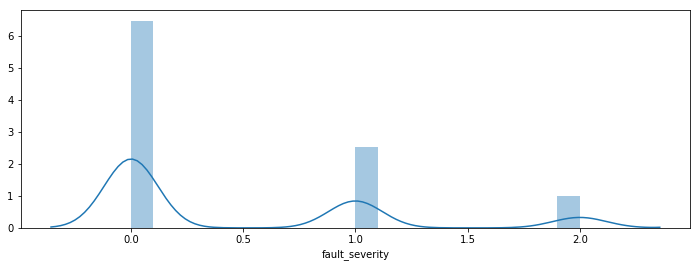

In [66]:
#histogram
import seaborn as sns
sns.distplot(train_mod['fault_severity']);

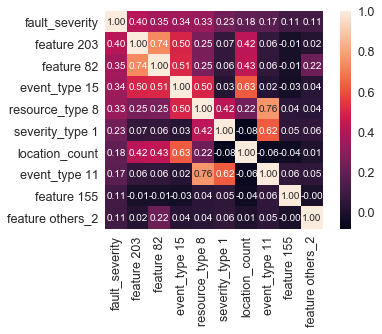

In [70]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'fault_severity')['fault_severity'].index
cm = np.corrcoef(train_mod[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [72]:
#missing data
total = train_mod.isnull().sum().sort_values(ascending=False)
percent = (train_mod.isnull().sum()/train_mod.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
feature_count,0,0.0
feature 172,0,0.0
feature 197,0,0.0
feature 196,0,0.0
feature 195,0,0.0
feature 193,0,0.0
feature 191,0,0.0
feature 188,0,0.0
feature 182,0,0.0
feature 181,0,0.0
